In [67]:
## Correlation stability using NHANES

import nhanes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nhanes.load import load_NHANES_data, load_NHANES_metadata, open_dataset_page
import scipy.stats

from sklearn.preprocessing import quantile_transform
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score


In [2]:

data_df = load_NHANES_data(year='2017-2018')
metadata_df = load_NHANES_metadata(year='2017-2018')

def get_good_variables(data_df, thresh=5000):
    float_columns = [i for i in data_df.columns if data_df[i].dtype == np.float64]
    data_df_float = data_df[float_columns]
    
    sum_nona = data_df_float.notna().sum()
    
    data_df_float_thresh = data_df[sum_nona[sum_nona > thresh].index]
    return(data_df_float_thresh)

transform_data = False

if transform_data:
    data_df_orig = get_good_variables(data_df)
    data_df = pd.DataFrame(quantile_transform(data_df_orig),
                           index=data_df_orig.index,
                           columns=data_df_orig.columns)

data_df.shape

/Users/poldrack/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (142) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(8366, 197)

In [32]:
cc=data_df.corr()
highcorr = np.where(cc.abs()>0.2)
for i in range(len(highcorr[0])):
    x, y = highcorr[0][i], highcorr[1][i]
    if cc.iloc[x,y] < 1:
        print(cc.index[x], cc.columns[y], cc.iloc[x,y])

AgeStoppedBreastfeedingdays AgeFirstFedFormuladays 0.26809583836345324
AgeStoppedBreastfeedingdays AgeStartedOtherFoodbeverage 0.28236690883345567
AgeFirstFedFormuladays AgeStoppedBreastfeedingdays 0.26809583836345324
AgeFirstFedFormuladays AgeStoppedReceivingFormuladays 0.3048199742542236
AgeFirstFedFormuladays AgeStartedOtherFoodbeverage 0.4386461359130324
AgeStoppedReceivingFormuladays AgeFirstFedFormuladays 0.3048199742542236
AgeStoppedReceivingFormuladays AgeStartedOtherFoodbeverage 0.38478706743512575
AgeStoppedReceivingFormuladays AgeFirstFedMilkdays 0.2345772318817218
AgeStartedOtherFoodbeverage AgeStoppedBreastfeedingdays 0.28236690883345567
AgeStartedOtherFoodbeverage AgeFirstFedFormuladays 0.4386461359130324
AgeStartedOtherFoodbeverage AgeStoppedReceivingFormuladays 0.38478706743512575
AgeStartedOtherFoodbeverage AgeFirstFedMilkdays 0.22286694532576845
AgeFirstFedMilkdays AgeStoppedReceivingFormuladays 0.2345772318817218
AgeFirstFedMilkdays AgeStartedOtherFoodbeverage 0.2228

(5951, 2)
0.20937532446106277


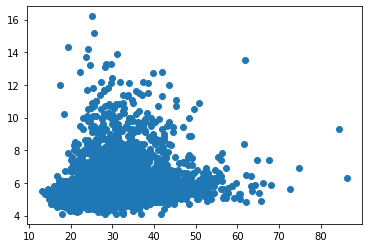

In [4]:
plt.scatter(data_df['BodyMassIndexKgm2'], data_df['Glycohemoglobin'])

selected_df = data_df[['BodyMassIndexKgm2', 'Glycohemoglobin']].dropna()
print(selected_df.shape)
corr = selected_df.corr().iloc[0, 1]
print(corr)

In [5]:
# get corridor of stability


step_size = 10
min_size = 10
max_size = 500

sample_sizes = np.arange(min_size, max_size, step_size)

corrs = pd.DataFrame(index = sample_sizes)

nruns = 1000
for run in range(nruns):
    sample_df = selected_df.sample(max_size)
    for sample_size in sample_sizes:
        corrs.loc[sample_size, run] = sample_df.iloc[:sample_size,:].corr().iloc[0,1]

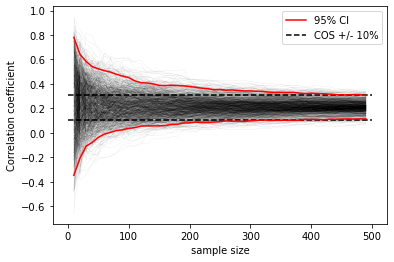

In [18]:
ci = pd.DataFrame({'upper': np.zeros(len(sample_sizes)),
                   'lower': np.zeros(len(sample_sizes))},
                  index = sample_sizes)
for sample_size in sample_sizes:
    ci.loc[sample_size, 'upper'] = scipy.stats.scoreatpercentile(corrs.loc[sample_size,:], 97.5)
    ci.loc[sample_size, 'lower'] = scipy.stats.scoreatpercentile(corrs.loc[sample_size,:], 2.5)
    
_ = plt.plot(corrs, linewidth=0.1, alpha=0.3, color='k')
plt.xlabel('sample size')
plt.ylabel('Correlation coefficient')
plt.plot(ci['upper'], color='r', label='95% CI')
plt.plot(ci['lower'], color='r')
plt.hlines([corr - 0.1, corr + 0.1], xmin=0, xmax=500, linestyles='dashed', label='COS +/- 10%')
_ = plt.legend()
plt.savefig('correlation_stability.pdf')

/Users/poldrack/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2663: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  warnings.warn("The default value of `copy` will change from False to "


(5264, 4)
                                  SmokedAtLeast100CigarettesInLife  \
SmokedAtLeast100CigarettesInLife                          1.000000   
BloodCadmiumUgl                                           0.387102   
AgeInYearsAtScreening                                     0.165573   
Gender                                                   -0.207783   

                                  BloodCadmiumUgl  AgeInYearsAtScreening  \
SmokedAtLeast100CigarettesInLife         0.387102               0.165573   
BloodCadmiumUgl                          1.000000               0.234742   
AgeInYearsAtScreening                    0.234742               1.000000   
Gender                                   0.138897              -0.021088   

                                    Gender  
SmokedAtLeast100CigarettesInLife -0.207783  
BloodCadmiumUgl                   0.138897  
AgeInYearsAtScreening            -0.021088  
Gender                            1.000000  


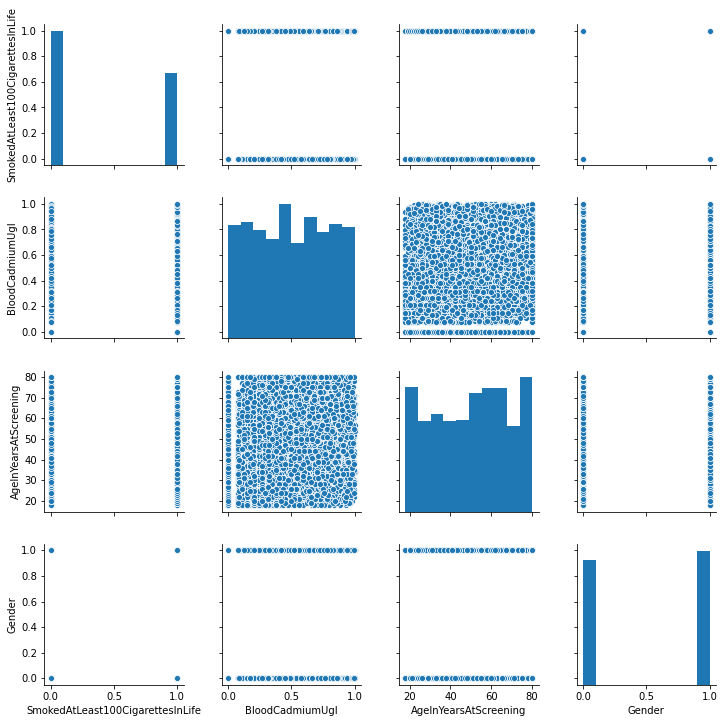

In [49]:
# same for cross-validation
selected_df = data_df[['SmokedAtLeast100CigarettesInLife', 'BloodCadmiumUgl', 'AgeInYearsAtScreening', 'Gender']].dropna()
selected_df['Gender'] = [1 if i == 'Female'  else 0 for i in selected_df.Gender]
selected_df['BloodCadmiumUgl'] = quantile_transform(selected_df['BloodCadmiumUgl'].values[:, np.newaxis], output_distribution='uniform')
print(selected_df.shape)
corr = selected_df.corr()
print(corr)

import seaborn as sns
%matplotlib inline 

sns.pairplot(selected_df)
plt.show()

In [70]:
# predict smoking status from age, gender, and blood cadmium level

# first run on full sample

X = selected_df[['BloodCadmiumUgl', 'AgeInYearsAtScreening', 'Gender']].values
y = selected_df[['SmokedAtLeast100CigarettesInLife']].values[:, 0]


In [135]:
nruns = 1000
accuracy_fullsample = np.zeros(nruns)
test_size = 0.25

pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])

for run in range(nruns):

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        stratify=y,
                                                        test_size=test_size)
    pipe.fit(X_train, y_train)
    pred_full = pipe.predict(X_test)
    accuracy_fullsample[run] = balanced_accuracy_score(y_test, pred_full)


Text(0.5, 0, 'Accuracy (full sample)')

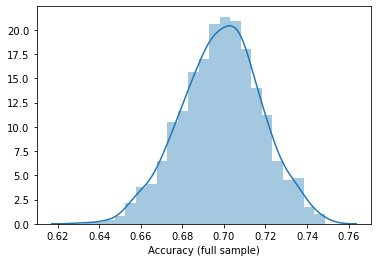

In [136]:
# Plot distribution across splits

sns.distplot(accuracy_fullsample)
plt.xlabel('Accuracy (full sample)')

In [137]:
# compute crossvalidation across sample sizes from 20 to 1000

sample_sizes = np.hstack((np.arange(20, 400, 20), np.arange(400, 4000, 100)))
nruns = 1000

accuracy = pd.DataFrame()

ctr = 0
for sample_size_index, sample_size in enumerate(sample_sizes):
    for run in range(nruns):
        sample_df = selected_df.sample(sample_size)
        
        X = sample_df[['BloodCadmiumUgl', 'AgeInYearsAtScreening', 'Gender']].values
        y = sample_df[['SmokedAtLeast100CigarettesInLife']].values[:, 0]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            stratify=y,
                                                            test_size=test_size)
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)
        accuracy.loc[ctr, 'sample_size'] = int(sample_size)
        accuracy.loc[ctr, 'score'] = balanced_accuracy_score(y_test, pred)
        ctr += 1
    

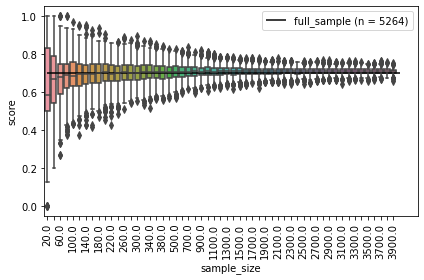

In [139]:
boxplot = sns.boxplot(x='sample_size', y='score', data=accuracy)
_ = boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation=90)
for label in boxplot.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
plt.hlines([np.mean(accuracy_fullsample)], xmin=0, xmax=len(sample_sizes), label='full_sample (n = %d)' % selected_df.shape[0])
plt.legend()
plt.tight_layout()
plt.savefig('accuracy_by_samplesize.pdf')